# Generating Training Data

In [60]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np
import time

In [162]:
def read_img(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [159]:
def show_img(img):
    plt.imshow(img)
    plt.show()

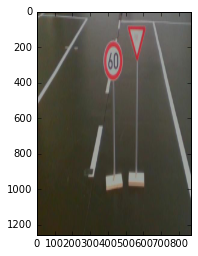

In [160]:
img = read_img("/Users/florian/traffic-signs-dataset/cropped/1.png")
show_img(img)

## Sliding Windows

There's a pretty good explination here: http://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
I also adapted the code for drawing the sliding windows into the original image from there.

In [80]:
class WindowSlider:
    def __init__(self, shape, moveX, moveY, sizes):
        self.shape = shape
        self.moveX = moveX
        self.moveY = moveY
        self.sizes = sizes
        
    def slide(self, img):
        height, width, _ = img.shape
        
        for y in range(0, height - self.shape[1], self.moveY):
            for x in range(0, width - self.shape[0], self.moveX):
                yield x, y, img[y:y + self.shape[1], x:x + self.shape[0]]

### Showing the individual windows

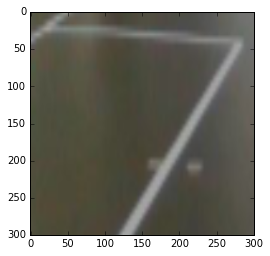

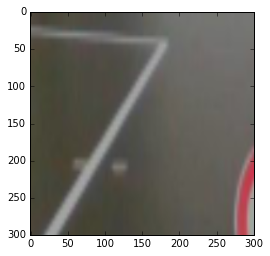

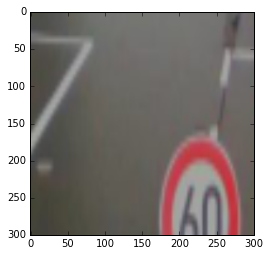

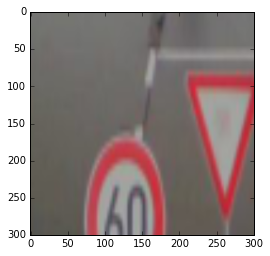

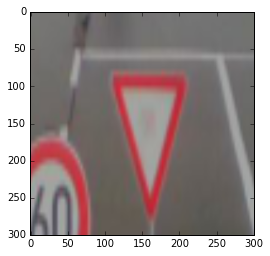

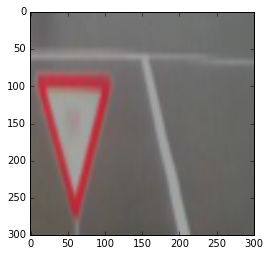

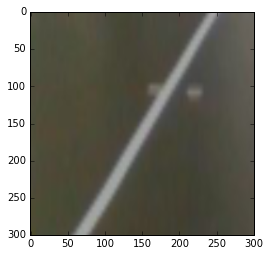

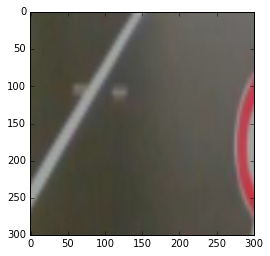

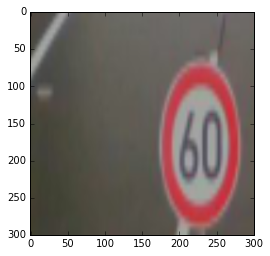

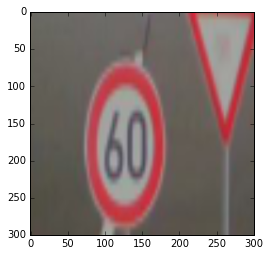

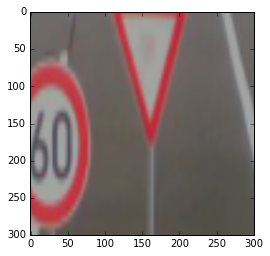

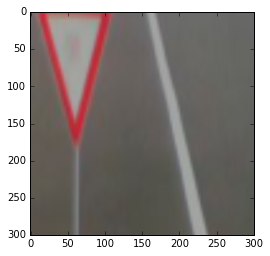

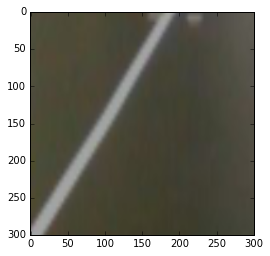

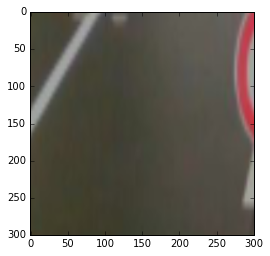

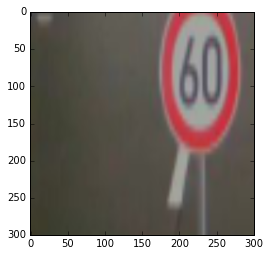

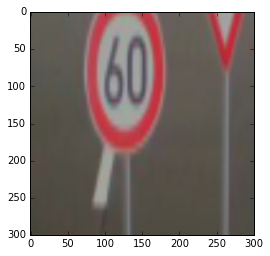

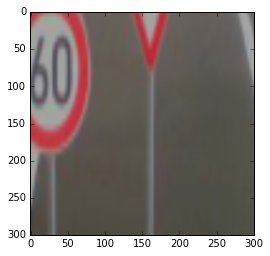

KeyboardInterrupt: 

In [84]:
slider = WindowSlider(shape=(300, 300), moveX=100, moveY=100, sizes=(1))

for x, y, window in slider.slide(image):
    plt.imshow(window)
    plt.show()

### Drawing the windows into the original image

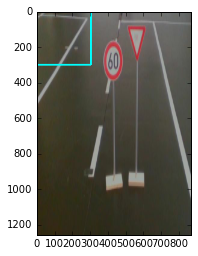

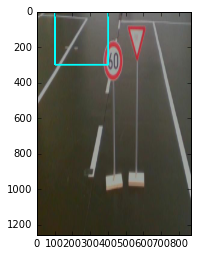

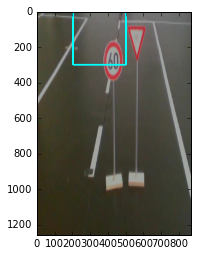

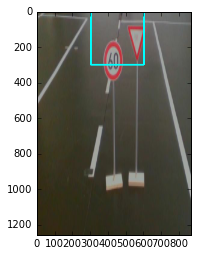

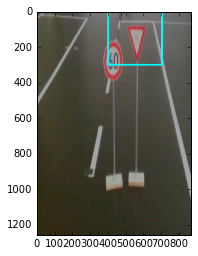

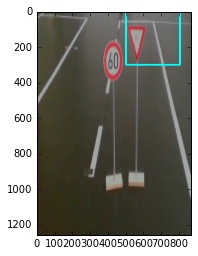

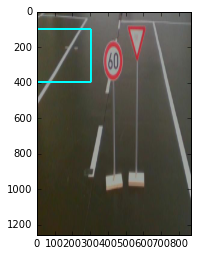

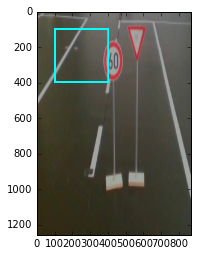

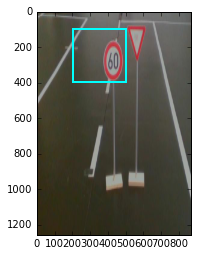

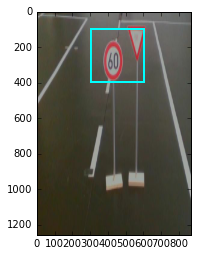

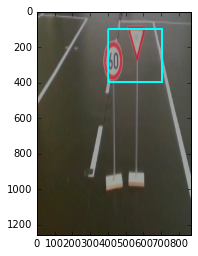

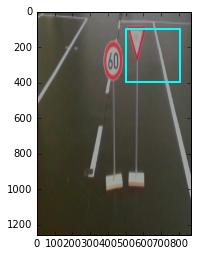

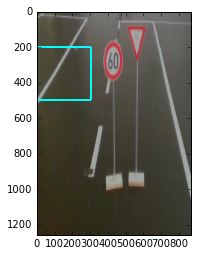

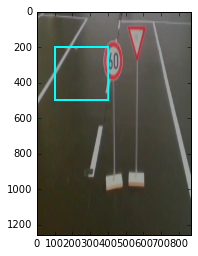

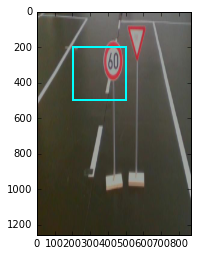

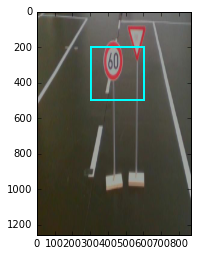

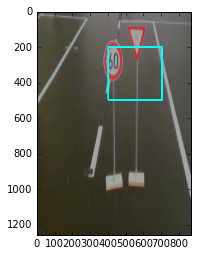

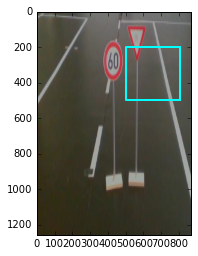

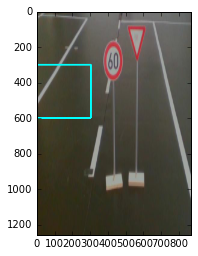

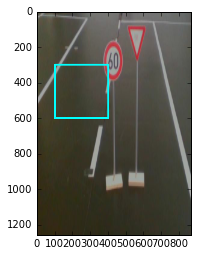

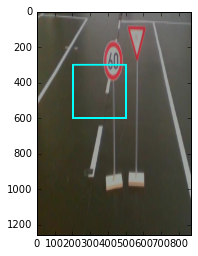

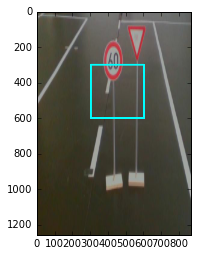

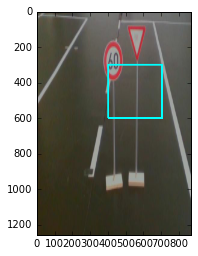

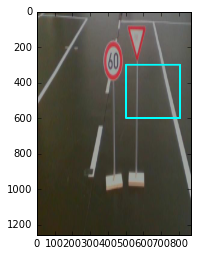

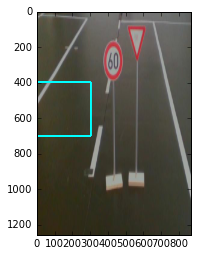

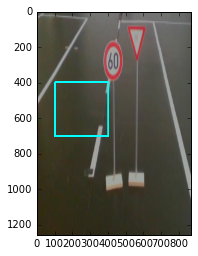

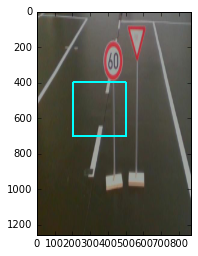

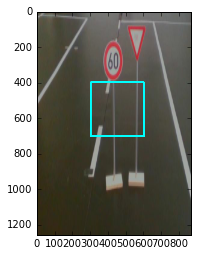

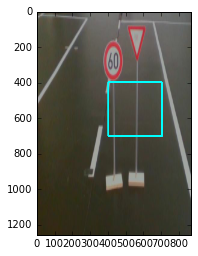

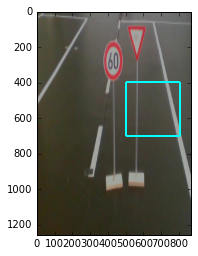

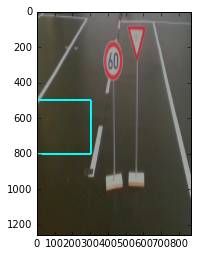

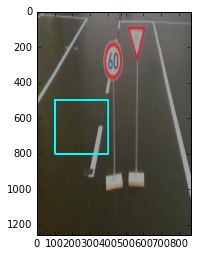

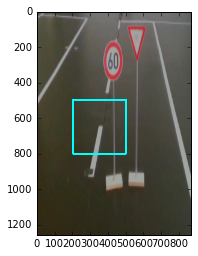

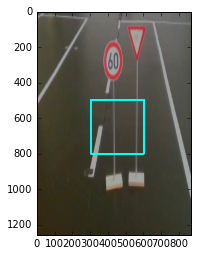

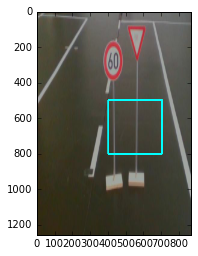

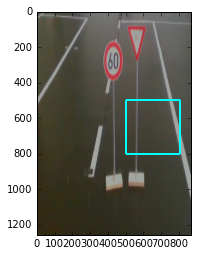

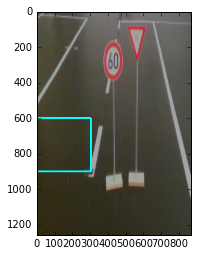

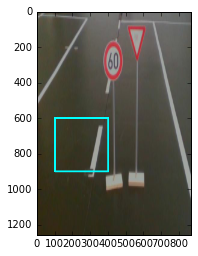

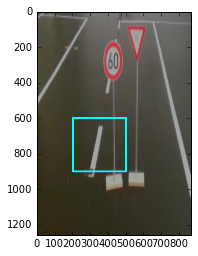

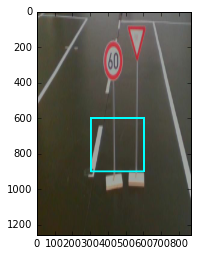

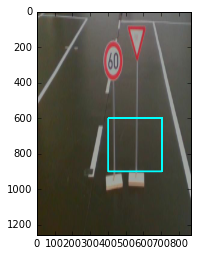

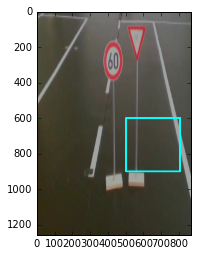

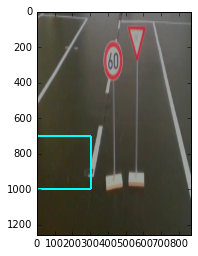

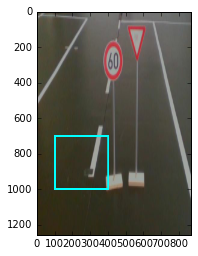

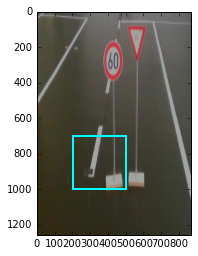

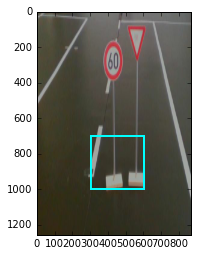

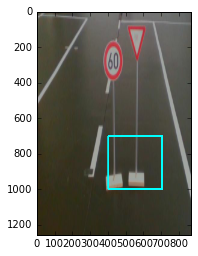

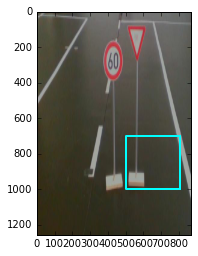

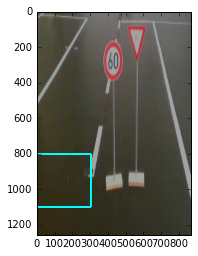

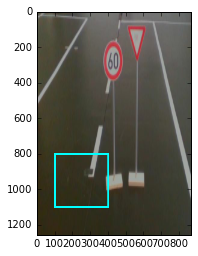

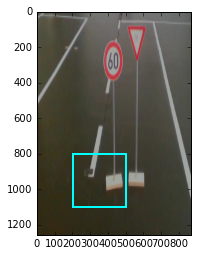

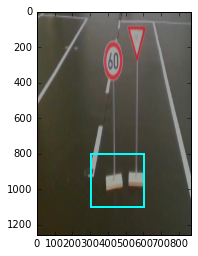

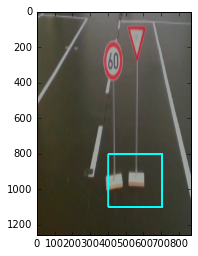

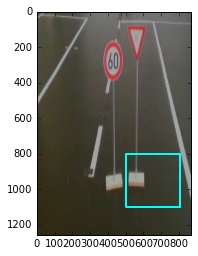

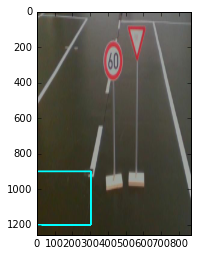

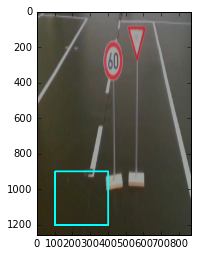

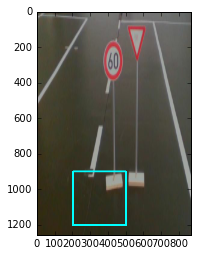

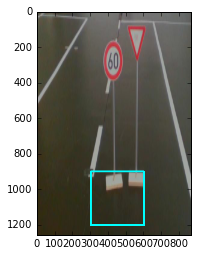

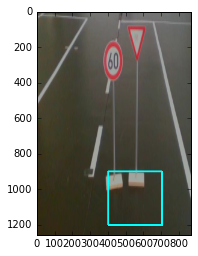

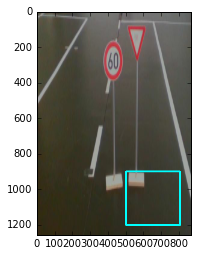

In [82]:
shape = (300, 300)
slider = WindowSlider(shape=shape, moveX=100, moveY=100, sizes=(1))

for x, y, window in slider.slide(image):
    clone = img.copy()
    cv2.rectangle(clone, (x, y), (x + shape[0], y + shape[1]), (0, 255, 255), 10)
    plt.imshow(clone)
    plt.show()

## Color Heuristics

The idea here is to convert the image colors from RGB to HSV, because HSV allows us to check the color without taking care of lightning or saturation.

Here's a scale for the values that H (hue) takes.
![hsv scale](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/HueScale.svg/743px-HueScale.svg.png)

OpenCV seems to scale down the values from [0, 360] to [0, 180], so a this image is not totally accurate for us. A little bit of trying out values is also required to find suitable ones.

We will be using the following image for testing:

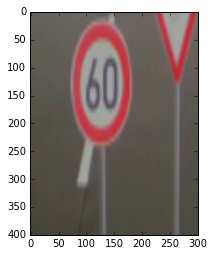

In [197]:
img = read_img("/Users/florian/traffic-signs-dataset/cropped/1.png")
red_img = img[150:550, 300:600]
show_img(red_img)

To check if an HSV value corresponds to certain colors, we can use a small helper class:

In [337]:
class HSV:
    # A list of bounds, each containing a lower and an upper bound
    BOUNDS = {
        "RED": [(170, 180)],
        "YELLOW": [(17, 17)]
    }
    
    @staticmethod
    def is_color(color, hue):
        for lower, upper in HSV.BOUNDS[color]:
            if lower <= hue <= upper:
                return True
            
        return False

In [272]:
# A generator that yields for every pixel the hue
def loop_hsv_pixels(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)    
    
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            hue, _, _ = img[y, x]
            yield x, y, hue

We can use these helper functions to create a function that counts the percentage of pixels that are close to the given color:

In [288]:
def ratio_of_pixels_in_color(img, target_color):
    count = 0
    total = img.shape[0] * img.shape[1]
    
    for x, y, hue in loop_hsv_pixels(img):
        if HSV.is_color(target_color, hue):
            count += 1
        
    return float(count) / total

In [289]:
ratio_of_pixels_in_color(red_img, "RED")

0.11504166666666667

To check if we're really counting the correct pixels, we can use a small helper function that colors all counted pixels green:

def recolor_found_pixels(img, target_color):
    new_img = img.copy()

    for x, y, hue in loop_hsv_pixels(img):
        if HSV.is_color(target_color, hue):
            new_img[y, x] = [0, 255, 0]

    show_img(new_img)

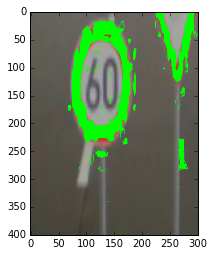

In [298]:
recolor_found_pixels(red_img, "RED")

This heuristic mostly works fine, but there can be substantial false positives. E.g. in the image below, we'r coloring a part of the image above the red triangle, even though there's no sign.

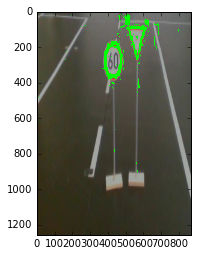

In [299]:
recolor_found_pixels(img, "RED")

For yellow it doesn't work as well. Even when severely limiting the hue values, there' still a lot of false positives. And limiting the hue value to a single one is probably also overfitting.

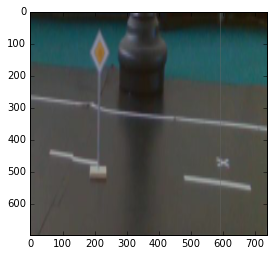

In [301]:
yellow_img = read_img("/Users/florian/traffic-signs-dataset/cropped/52.png")
show_img(yellow_img)

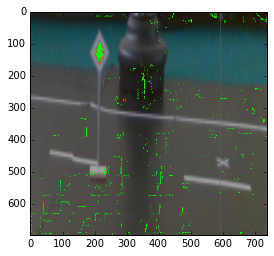

In [338]:
recolor_found_pixels(yellow_img, "YELLOW")

## Using the color heuristic to find relevant windows

We can use the sliding window functionality, combined with the color heuristic, to find relevant parts of the image.

This kind of works, but doesn't produce high quality bounding boxes.

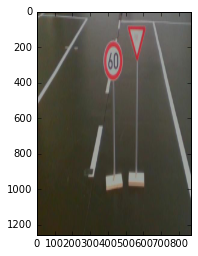

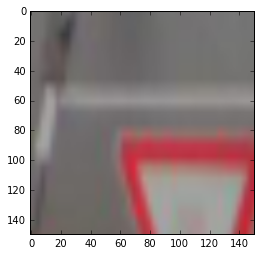

0.244844444444


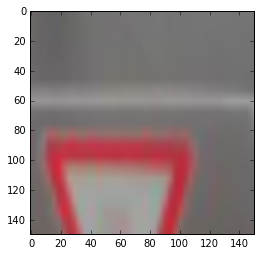

0.263911111111


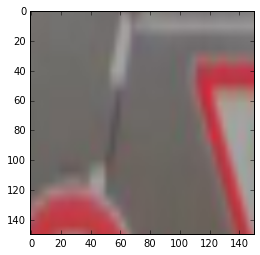

0.229333333333


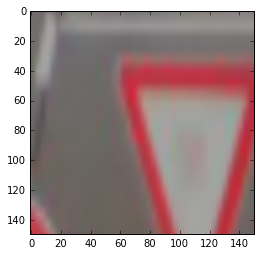

0.275466666667


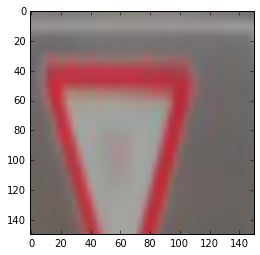

0.298666666667


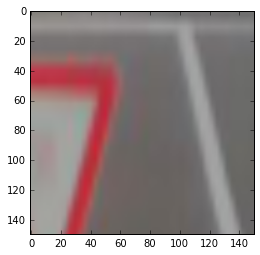

0.201688888889


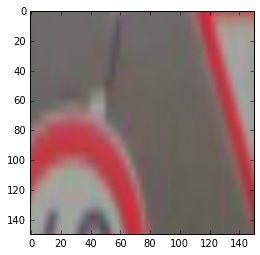

0.217111111111


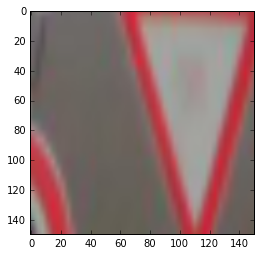

0.252177777778


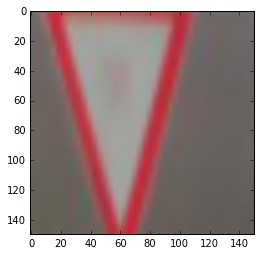

0.214977777778


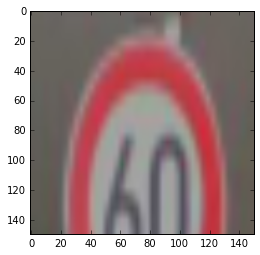

0.252533333333


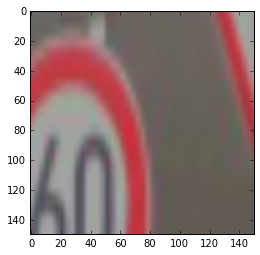

0.216444444444


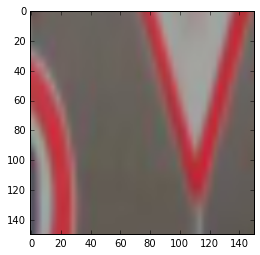

0.236444444444


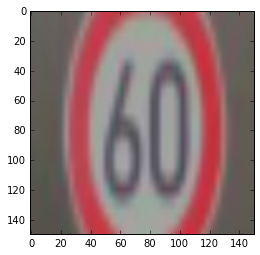

0.264622222222


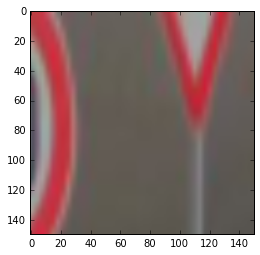

0.202


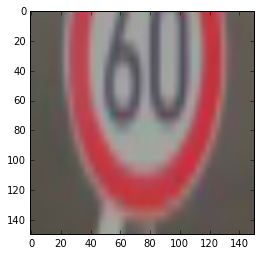

0.2576


In [300]:
color = "RED"

slider = WindowSlider(shape=(150, 150), moveX=50, moveY=50, sizes=(1))
img = read_img("/Users/florian/traffic-signs-dataset/cropped/1.png")
show_img(img)

for x, y, window in slider.slide(img):
    percentage_red_pixels = ratio_of_pixels_in_color(window, color)
    if percentage_red_pixels > 0.2:
        show_img(window)
        print percentage_red_pixels